<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: left; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
    NYC Airbnb: EDA, Visualization, Regression<br>
</div>

<img src="https://i.imgur.com/UIQCjMy.jpg" width="700px">

Photo by [Andre Benz](https://unsplash.com/@trapnation) on Unsplash

# <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">1. Dataset</div>

* **id**: listing ID
* **name**: name of the listing
* **host_id**: host ID
* **host_name**: name of the host
* **neighbourhood_group**: location
* **neighbourhood**: area
* **latitude**: latitude coordinates
* **longitude**: longitude coordinates
* **room_type**: listing space type
* **price**: price in dollars
* **minimum_nights**: amount of nights minimum
* **number_of_reviews**: number of reviews
* **last_review**: latest review
* **reviews_per_month**: number of reviews per month
* **calculated_host_listings_count**: amount of listing per host
* **availability_365**: number of days when listing is available for booking

In [1]:
!pip install autogluon.tabular > /dev/null 2>&1

In [2]:
# Import all libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # ploting the data
import seaborn as sns # ploting the data
import math # calculation
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

In [3]:
TIME_LIMIT = 3600 * 8  # Time limit in seconds for AutoGluon model

# <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">2. Exploratory Data Analysis</div>

* Examine the number of variable and columns  
* Check that the dataset is tidy  
    * Check that every row is an observation and every column is a variable  
    * Determine if there are missing values
* Examine variables distributions

In [4]:
# load the data
data = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

In [5]:
# Visualize data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

We drop the columns that are not of interest or could cause privacy isssues.  
See Dgomonov's work here:  https://www.kaggle.com/dgomonov/data-exploration-on-nyc-airbnb   

In [6]:
# Drop the data that are not of interest and/or causing privacy issues
data.drop(['id','host_name','last_review'], axis=1, inplace=True)
# Visualize the first 5 rows
data.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [7]:
# Determine the number of missing values for every column
data.isnull().sum()

name                                 16
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
#replacing all NaN values in 'reviews_per_month' with 0
# See https://www.kaggle.com/dgomonov/data-exploration-on-nyc-airbnb
data.fillna({'reviews_per_month':0}, inplace=True)

In [9]:
#examine the dataset
(data[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]
 .describe())

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [10]:
# Exclude property with listed price of 0
data = data.loc[data['price'] > 0]

In [11]:
#examine the dataset
data.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.090800,7.144628,112.779498
std,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.597213,32.956185,131.627271
min,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [12]:
# Recode data as categorical
# https://datascience.stackexchange.com/questions/29093/continuous-variable-to-categorical-by-quartiles
data_encoded = data.copy()
data_encoded['minimum_nights'] = pd.qcut(data['minimum_nights'], q=2, labels=["minimum_nights_low", "minimum_nights_high"])
data_encoded['number_of_reviews'] = pd.qcut(data['number_of_reviews'], q=3, labels=["number_of_reviews_low", "minimum_nights_medium", "number_of_reviews_high"])
data_encoded['reviews_per_month'] = pd.qcut(data['reviews_per_month'], q=2, labels=["reviews_per_month_low", "reviews_per_month_high"])
data_encoded['calculated_host_listings_count'] = pd.cut(data['calculated_host_listings_count'], 
                                                bins=[0, 2, 327],
                                                labels=["calculated_host_listings_count_low", "calculated_host_listings_count_high"])
data_encoded['availability_365'] = pd.qcut(data['availability_365'], q=2, labels=["availability_low", "availability_high"])

In [13]:
data_encoded.isnull().sum()

name                              16
host_id                            0
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [14]:
data_encoded.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,minimum_nights_low,minimum_nights_medium,reviews_per_month_low,calculated_host_listings_count_high,availability_high
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,minimum_nights_low,number_of_reviews_high,reviews_per_month_high,calculated_host_listings_count_low,availability_high
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,minimum_nights_low,number_of_reviews_low,reviews_per_month_low,calculated_host_listings_count_low,availability_high
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,minimum_nights_low,number_of_reviews_high,reviews_per_month_high,calculated_host_listings_count_low,availability_high
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,minimum_nights_high,minimum_nights_medium,reviews_per_month_low,calculated_host_listings_count_low,availability_low


In [15]:
# Replace inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop or fill NaN values if needed, depending on your requirement
data.dropna(inplace=True)

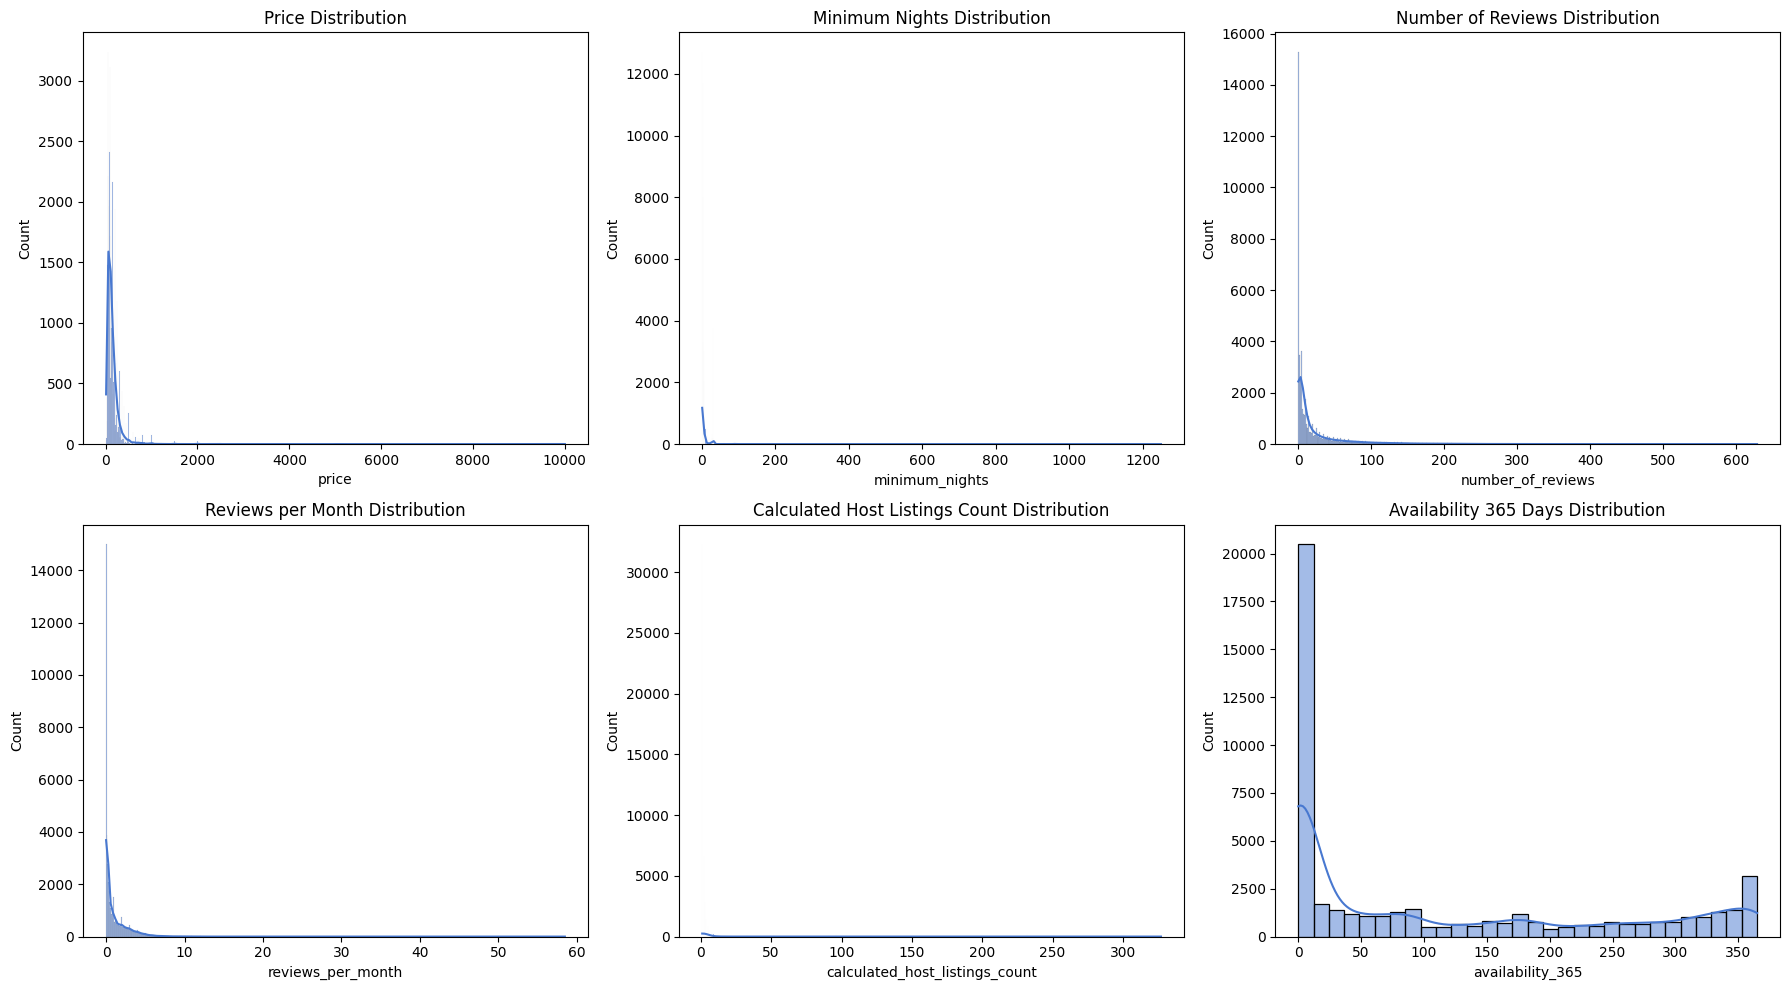

In [16]:
# Set the style for the plots
sns.set_palette("muted")
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Use sns.histplot() instead of sns.distplot() for better future compatibility
sns.histplot(data['price'], ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Price Distribution')

sns.histplot(data['minimum_nights'], ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Minimum Nights Distribution')

sns.histplot(data['number_of_reviews'], ax=axs[0, 2], kde=True)
axs[0, 2].set_title('Number of Reviews Distribution')

sns.histplot(data['reviews_per_month'], ax=axs[1, 0], kde=True)
axs[1, 0].set_title('Reviews per Month Distribution')

sns.histplot(data['calculated_host_listings_count'], ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Calculated Host Listings Count Distribution')

sns.histplot(data['availability_365'], ax=axs[1, 2], kde=True)
axs[1, 2].set_title('Availability 365 Days Distribution')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

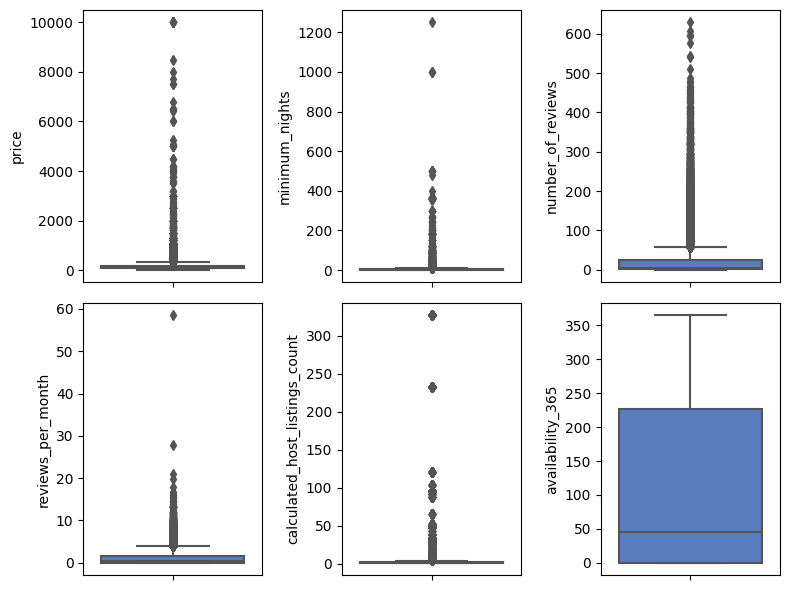

In [17]:
from pylab import *
f, ax = plt.subplots(figsize=(8, 6))

subplot(2,3,1)
sns.boxplot(y = data['price']) 

subplot(2,3,2)
sns.boxplot(y = data['minimum_nights'])

subplot(2,3,3)
sns.boxplot(y = data['number_of_reviews'])

subplot(2,3,4)
sns.boxplot(y = data['reviews_per_month'])

subplot(2,3,5)
sns.boxplot(y = data['calculated_host_listings_count'])

subplot(2,3,6)
sns.boxplot(y = data['availability_365'])

plt.tight_layout() # avoid overlap of plots
plt.draw()

* Most features are left-skewed. 
* I will use a log transform before the modeling step.

In [18]:
# Set up color blind friendly color palette
# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# sns.palplot(sns.color_palette(cbPalette))
# sns.palplot(sns.color_palette(cbbPalette))

sns.set_palette(cbPalette)
#sns.set_palette(cbbPalette)

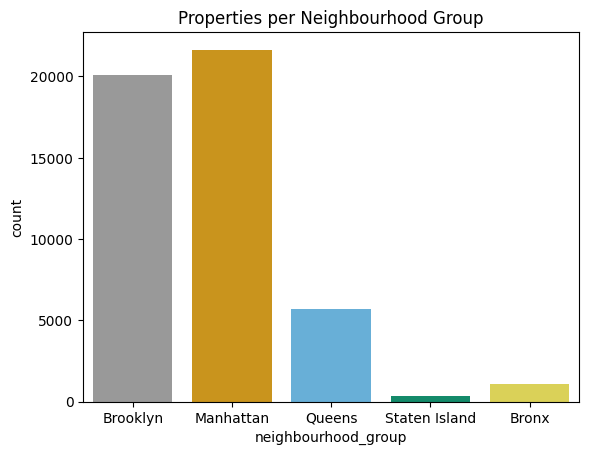

In [19]:
# Title for the plot
title = 'Properties per Neighbourhood Group'

# Corrected countplot with explicit `x` parameter
sns.countplot(x='neighbourhood_group', data=data)

# Set the title
plt.title(title)

# Display the plot
plt.show()

Most properties are located in Brooklyn and Manhattan.

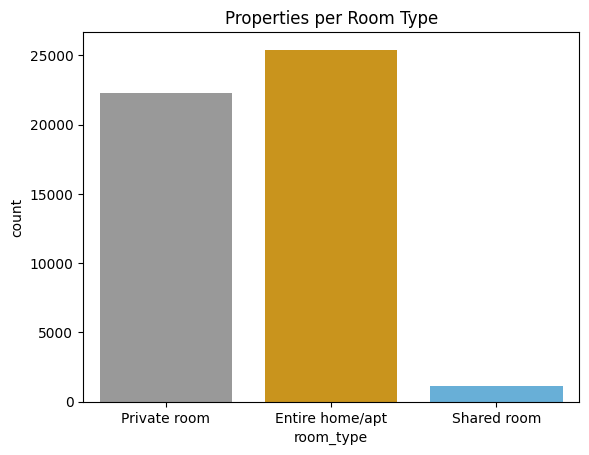

In [20]:
title = 'Properties per Room Type'
sns.countplot(x='room_type', data=data)
plt.title(title)
plt.show()


Most properties are Entire home or Private room.

# <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3. Visualization</div>

* Examine relation between location and price
* Examine relation between room type and price

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.1 Correlation</div>

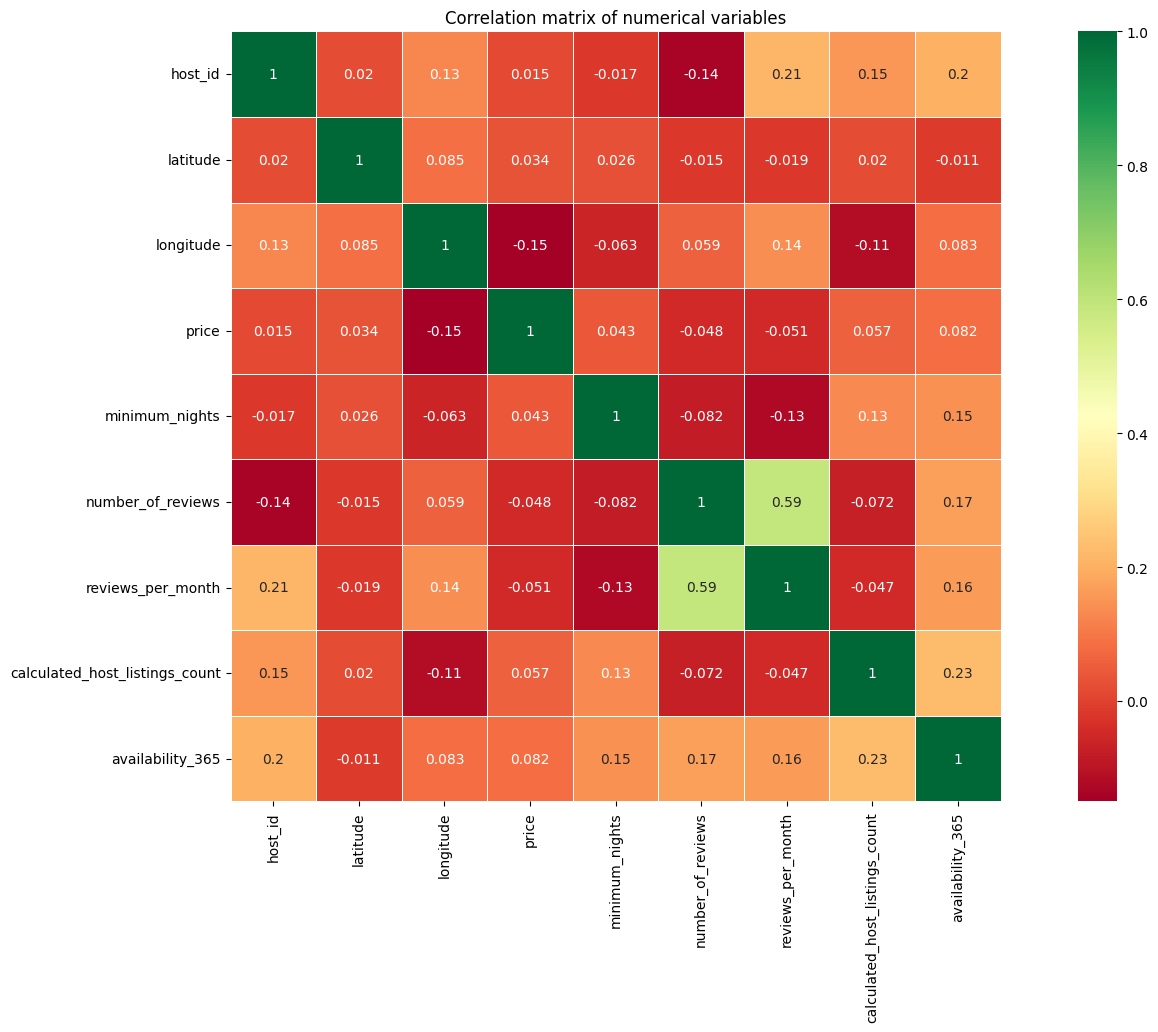

In [21]:
plt.figure(figsize=(20, 10))
title = 'Correlation matrix of numerical variables'
numeric_data = data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, square=True, cmap='RdYlGn', linewidths=0.5)
plt.title(title)
plt.show()

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.2 Location</div>

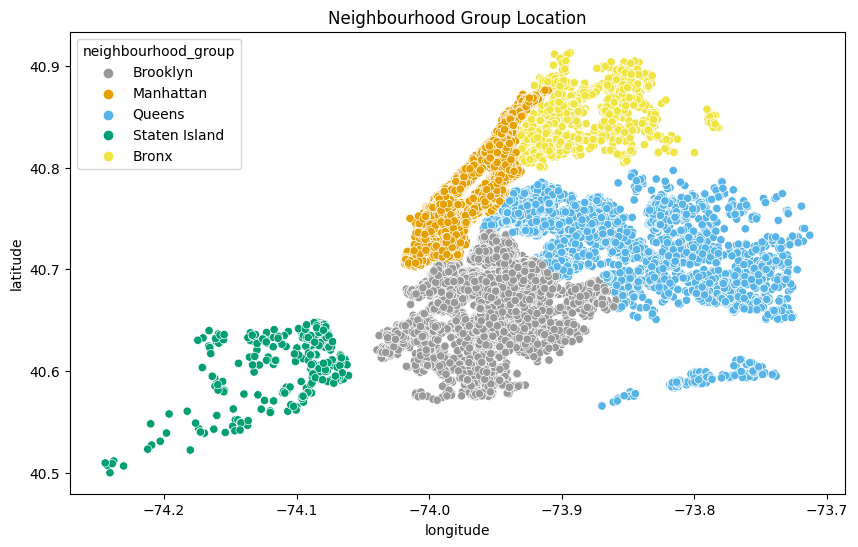

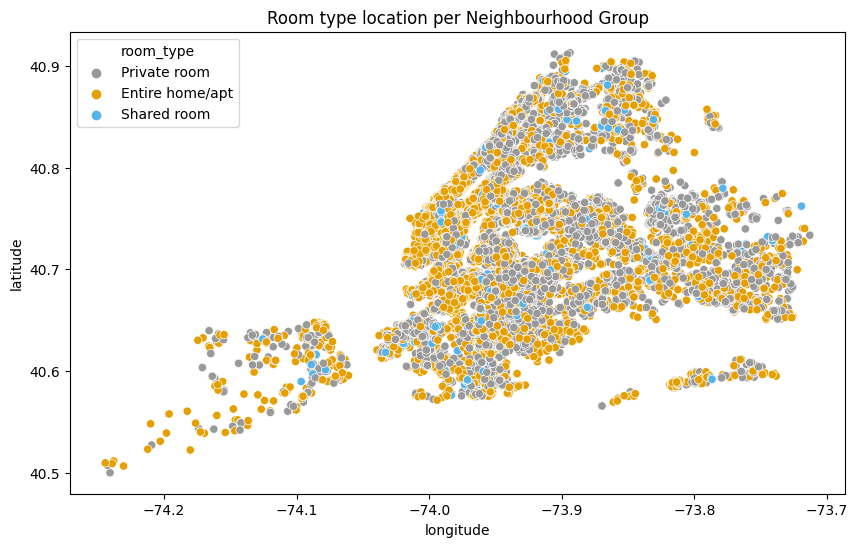

In [22]:
title = 'Neighbourhood Group Location'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', data=data).set_title(title)
plt.show()

title = 'Room type location per Neighbourhood Group'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='room_type', data=data).set_title(title)
plt.show()

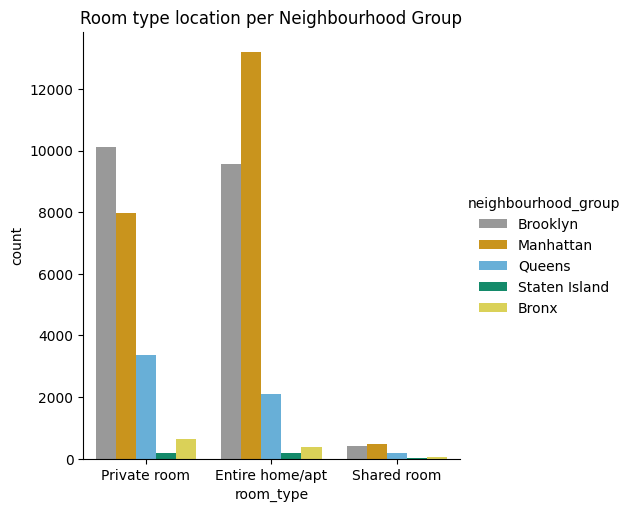

In [23]:
title = 'Room type location per Neighbourhood Group'
sns.catplot(x='room_type', kind="count", hue="neighbourhood_group", data=data);
plt.title(title)
plt.ioff()

* A majority of Entire home/apt are located in Manhattan
* A majority of private rooms are located in Brooklyn

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.3 Price relation to Neighbourhood Group</div>

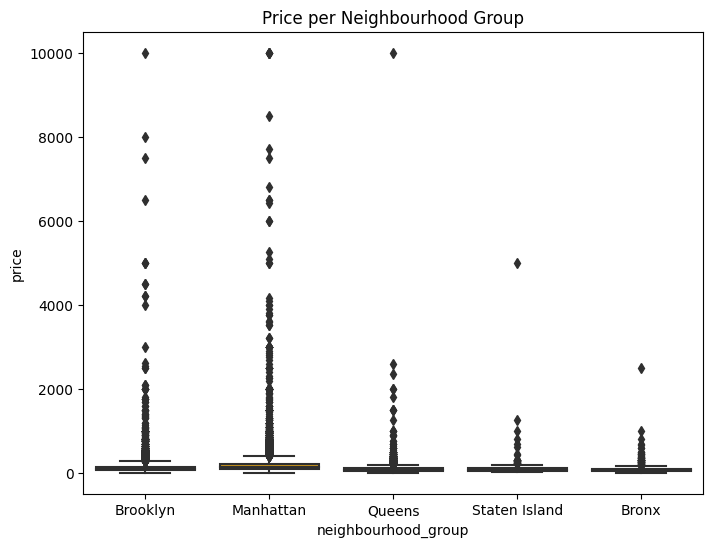

In [24]:
x = 'neighbourhood_group'
y = 'price'
title = 'Price per Neighbourhood Group'

f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data)
plt.title(title)
plt.show()

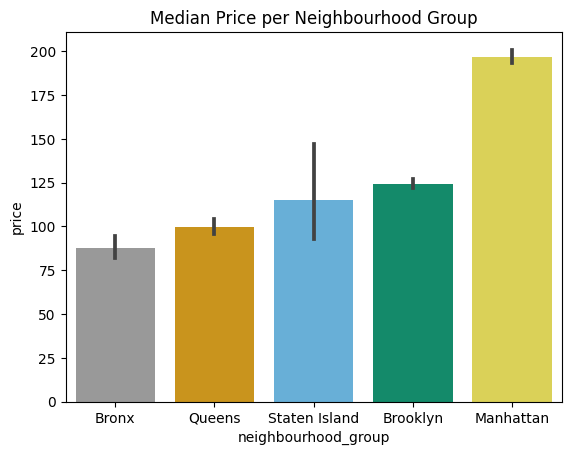

In [25]:
# alternative visualization of median less impacted by the extreme values
# see https://www.kaggle.com/nidaguler/eda-and-data-visualization-ny-airbnb

title = 'Median Price per Neighbourhood Group'
result = data.groupby(["neighbourhood_group"])['price'].aggregate(np.median).reset_index().sort_values('price')
sns.barplot(x='neighbourhood_group', y="price", data=data, order=result['neighbourhood_group'])
plt.title(title)
plt.show()

* Properties in Manhattan are more expensive
* The dataset can be separate between low price and high price properties

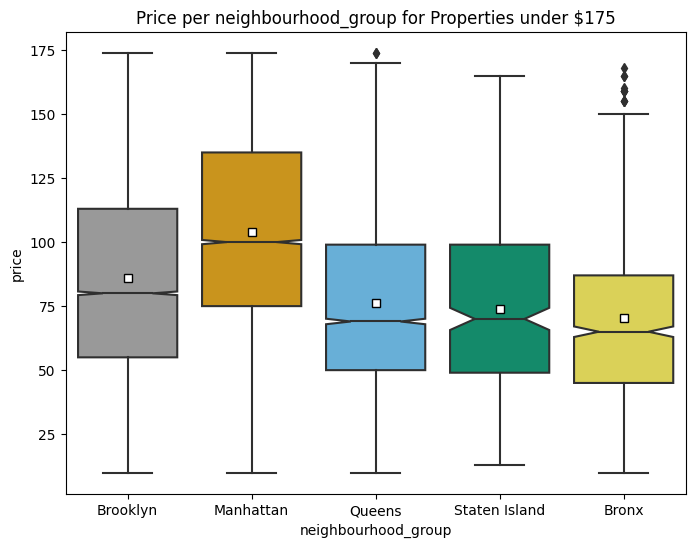

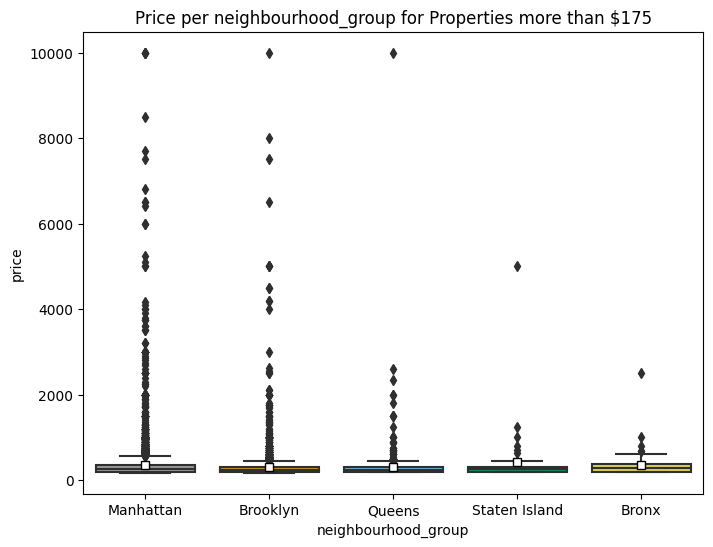

In [26]:
# https://stackoverflow.com/questions/54132989/is-there-a-way-to-change-the-color-and-shape-indicating-the-mean-in-a-seaborn-bo
x='neighbourhood_group'
y='price'

title = 'Price per neighbourhood_group for Properties under $175'
data_filtered = data.loc[data['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per neighbourhood_group for Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

In [27]:
# Is the location impact on price statiscaly significant?
# Use on way ANOVA and pairwise comaprison
# See https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/

import statsmodels.api as sm
from statsmodels.formula.api import ols

data_filtered = data.loc[data['price'] < 175]

mod = ols('price ~ neighbourhood_group',data=data_filtered).fit()

aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                           sum_sq       df           F  PR(>F)
neighbourhood_group  4.192295e+06      4.0  807.328851     0.0
Residual             4.664301e+07  35929.0         NaN     NaN


In [28]:
pair_t = mod.t_test_pairwise('neighbourhood_group')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Brooklyn-Bronx,15.599108,1.161859,13.425996,5.347797e-41,13.321830,17.876386,2.673899e-40,True
Manhattan-Bronx,33.609789,1.171252,28.695619,4.563816e-179,31.314100,35.905477,3.651053e-178,True
Queens-Bronx,6.119218,1.235535,4.952687,7.352746e-07,3.697532,8.540904,2.205822e-06,True
Staten Island-Bronx,3.721032,2.284161,1.629058,1.033095e-01,-0.755993,8.198056,1.959461e-01,False
Manhattan-Brooklyn,18.010681,0.422788,42.599797,0.000000e+00,17.182004,18.839358,0.000000e+00,True
Queens-Brooklyn,-9.479890,0.577465,-16.416376,2.423580e-60,-10.611739,-8.348040,1.696506e-59,True
Staten Island-Brooklyn,-11.878076,2.006069,-5.921071,3.227525e-09,-15.810031,-7.946121,1.291010e-08,True
Queens-Manhattan,-27.490571,0.596139,-46.114391,0.000000e+00,-28.659020,-26.322121,0.000000e+00,True
Staten Island-Manhattan,-29.888757,2.011524,-14.858765,8.583054e-50,-33.831404,-25.946110,5.149832e-49,True
Staten Island-Queens,-2.398186,2.049620,-1.170064,2.419831e-01,-6.415504,1.619131,2.419831e-01,False


Prices are significantly different depending between neighborhood groups for properties under $175.

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.4 Price relation to Room Type</div>

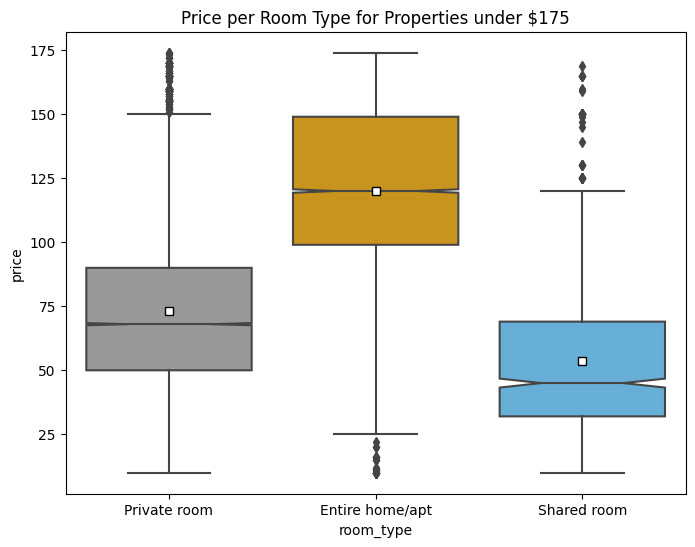

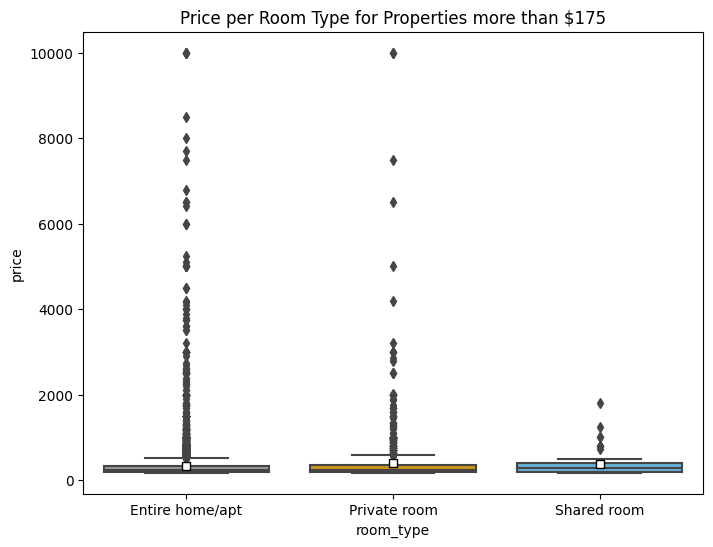

In [29]:
title = 'Price per Room Type for Properties under $175'
data_filtered = data.loc[data['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='room_type', y='price', data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per Room Type for Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='room_type', y='price', data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.5 Price relation to the number of review per month</div>

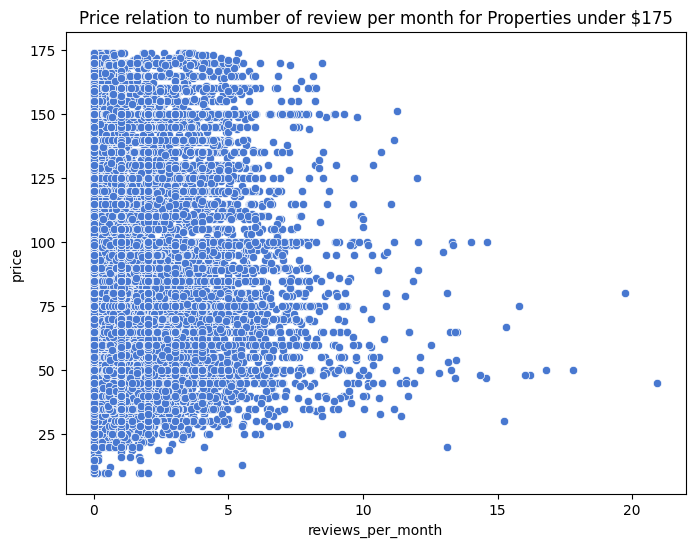

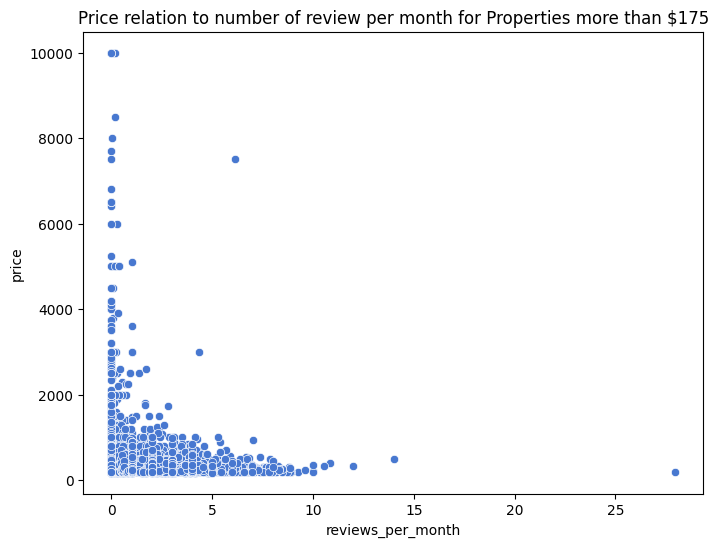

In [30]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'reviews_per_month'
y = 'price'

title = 'Price relation to number of review per month for Properties under $175'
data_filtered = data.loc[(data['price'] < 175) & (data['reviews_per_month'] < 30)]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()

title = 'Price relation to number of review per month for Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()
sns.set_palette(cbPalette)

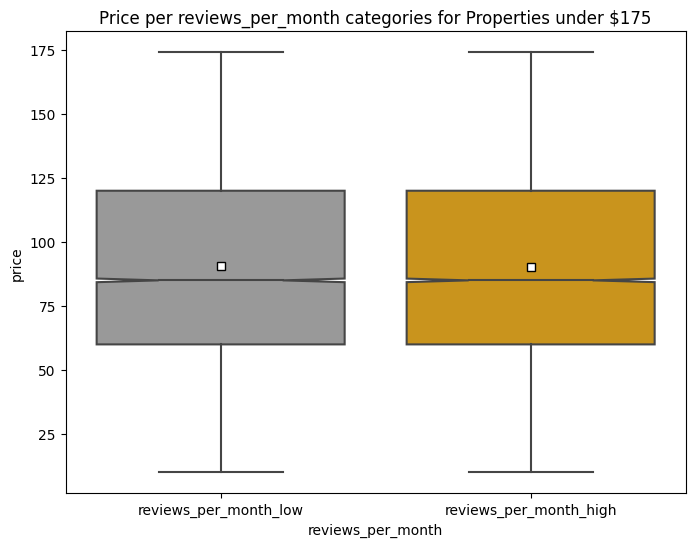

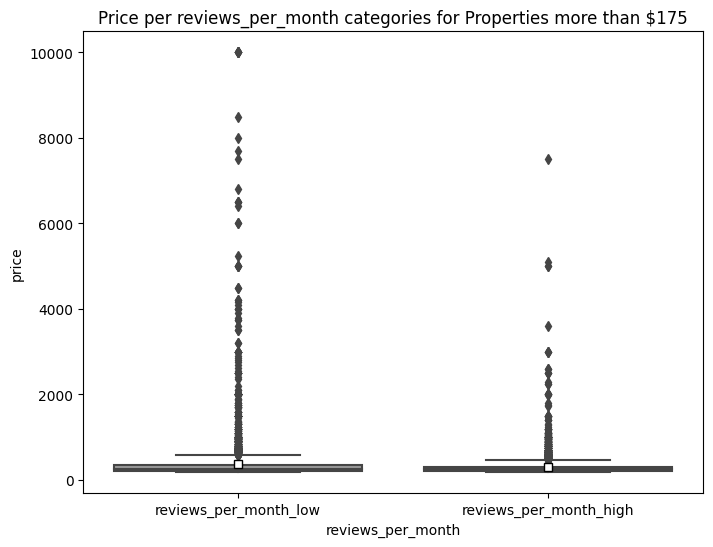

In [31]:
x='reviews_per_month'
y='price'

title = 'Price per reviews_per_month categories for Properties under $175'
data_filtered = data_encoded.loc[data_encoded['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per reviews_per_month categories for Properties more than $175'
data_filtered = data_encoded.loc[data_encoded['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.6 Price relation to the number_of_reviews</div>

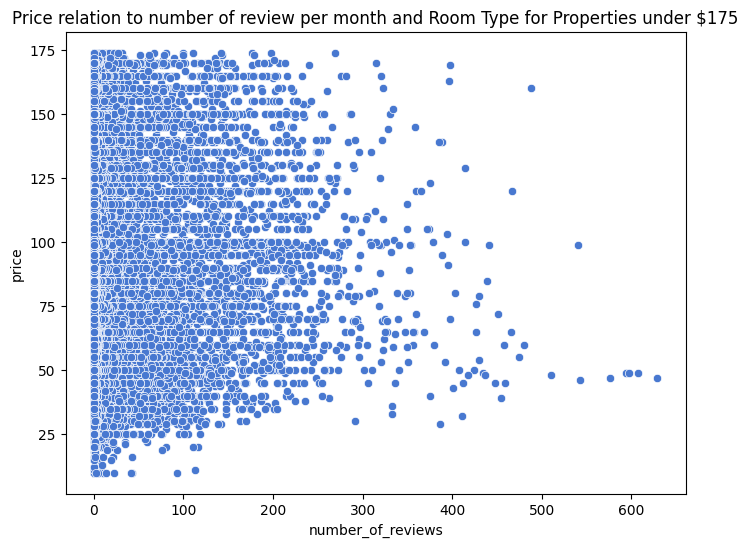

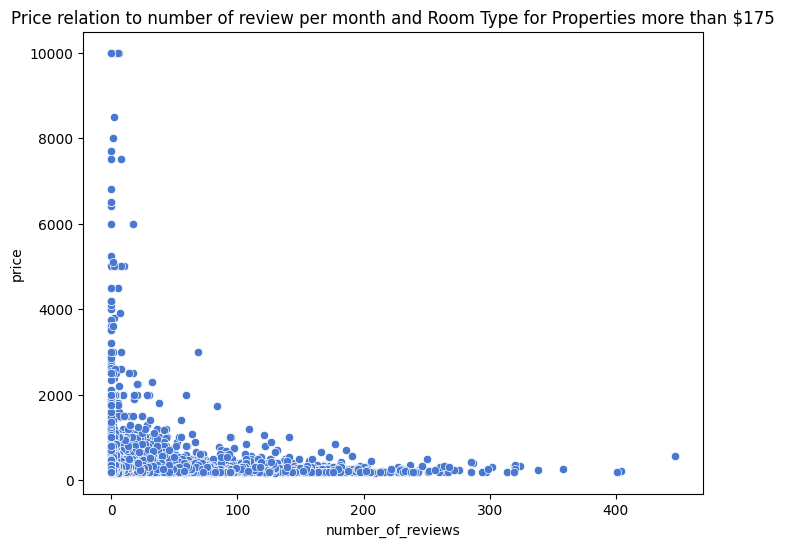

In [32]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'number_of_reviews'
y = 'price'

title = 'Price relation to number of review per month and Room Type for Properties under $175'
data_filtered = data.loc[data['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()

title = 'Price relation to number of review per month and Room Type for Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()
sns.set_palette(cbPalette)

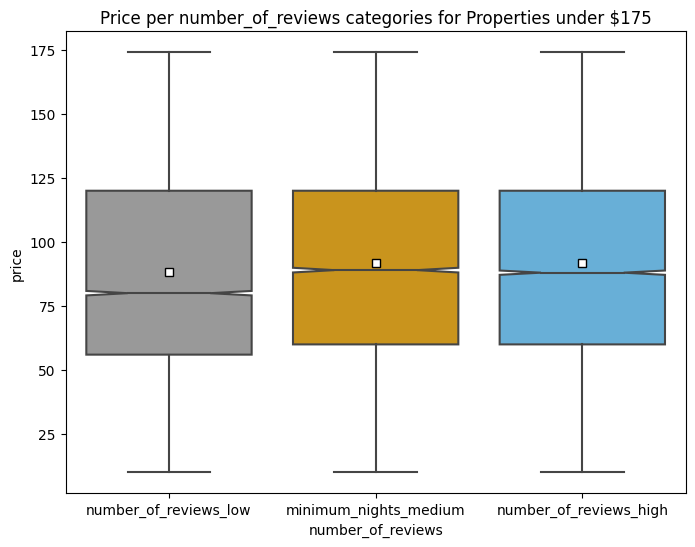

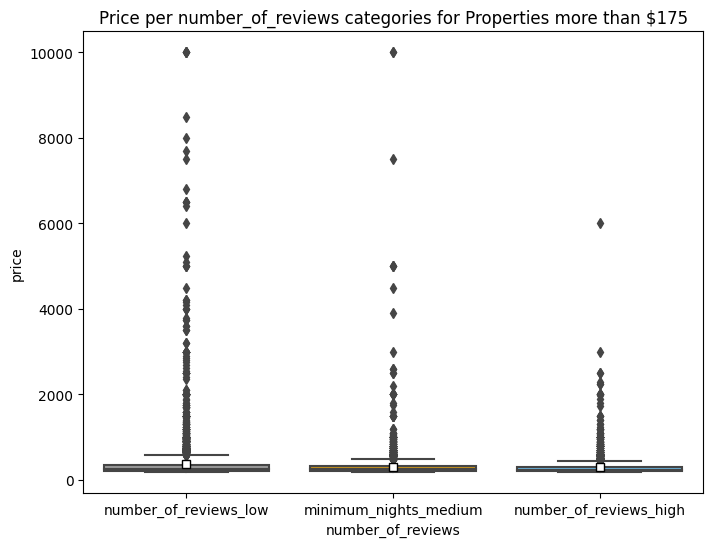

In [33]:
x = 'number_of_reviews'
y='price'

title = 'Price per number_of_reviews categories for Properties under $175'
data_filtered = data_encoded.loc[data_encoded['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per number_of_reviews categories for Properties more than $175'
data_filtered = data_encoded.loc[data_encoded['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.7 Price relation to minimum_nights</div>

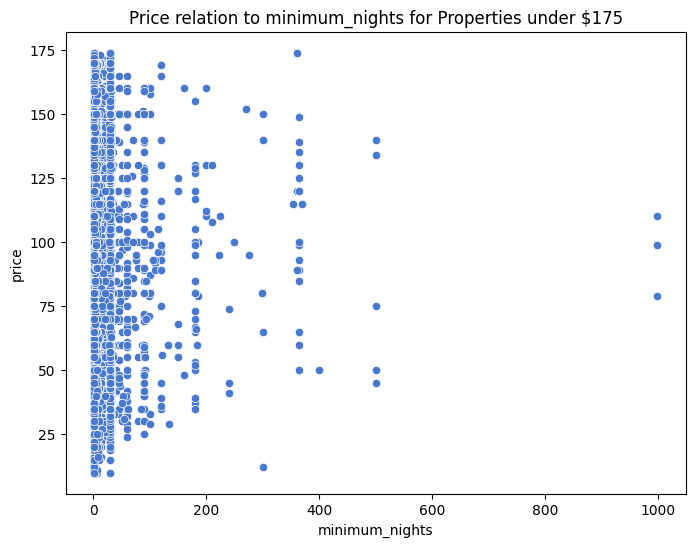

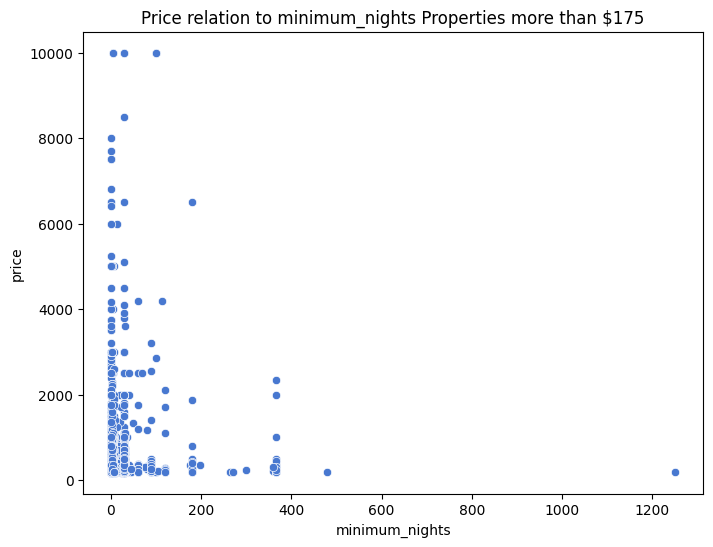

In [34]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'minimum_nights'
y = 'price'

title = 'Price relation to minimum_nights for Properties under $175'
data_filtered = data.loc[data['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()

title = 'Price relation to minimum_nights Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()
sns.set_palette(cbPalette)

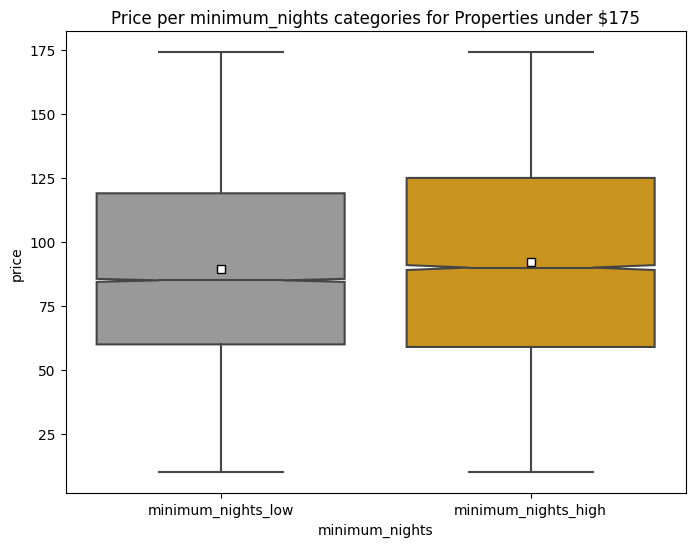

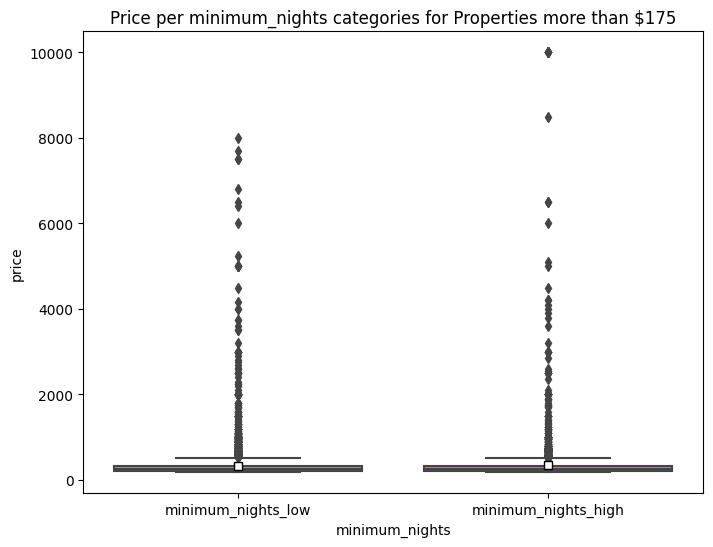

In [35]:
x = 'minimum_nights'
y='price'

title = 'Price per minimum_nights categories for Properties under $175'
data_filtered = data_encoded.loc[data_encoded['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per minimum_nights categories for Properties more than $175'
data_filtered = data_encoded.loc[data_encoded['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.8 Price relation to calculated_host_listings_count</div>

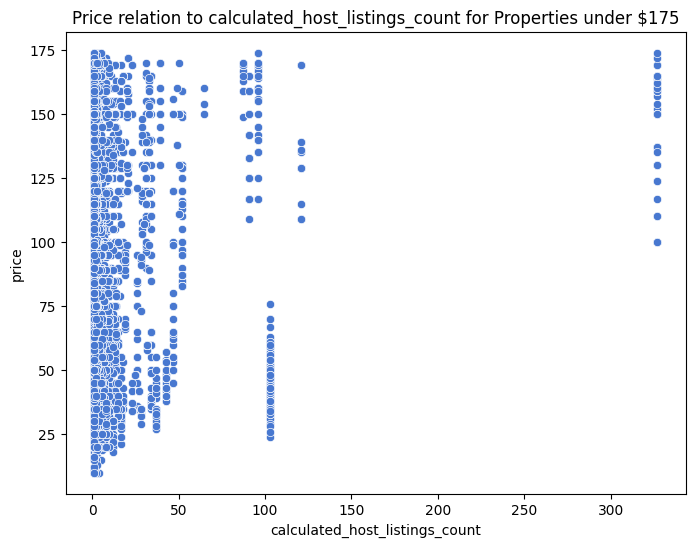

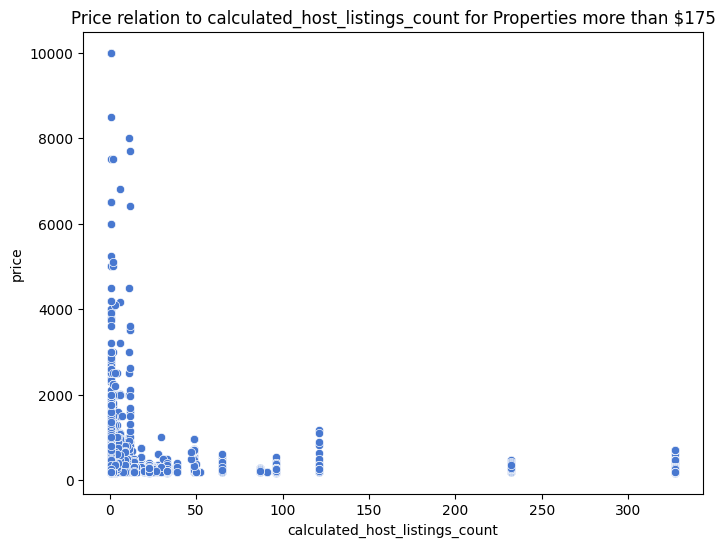

In [36]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'calculated_host_listings_count'
y = 'price'

title = 'Price relation to calculated_host_listings_count for Properties under $175'
data_filtered = data.loc[data['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()

title = 'Price relation to calculated_host_listings_count for Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()
sns.set_palette(cbPalette)

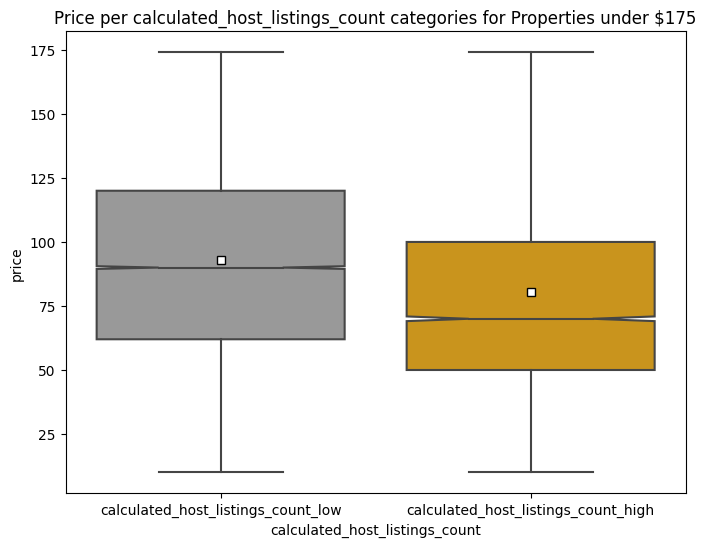

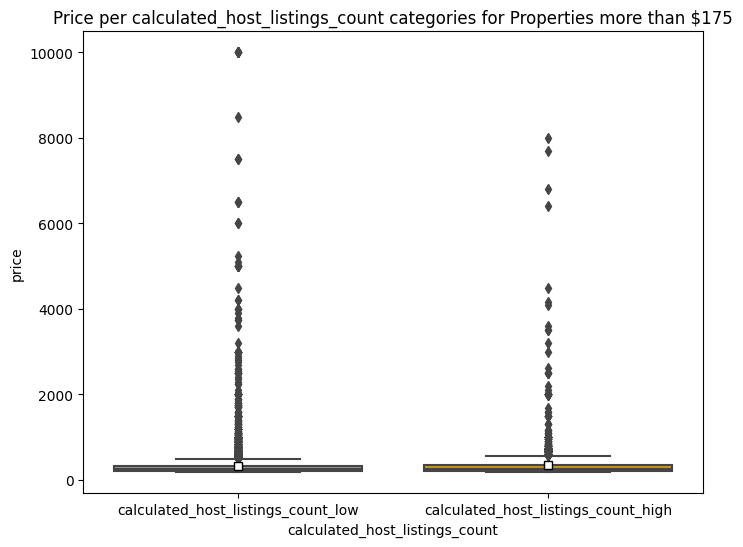

In [37]:
x = 'calculated_host_listings_count'
y='price'

title = 'Price per calculated_host_listings_count categories for Properties under $175'
data_filtered = data_encoded.loc[data_encoded['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per calculated_host_listings_count categories for Properties more than $175'
data_filtered = data_encoded.loc[data_encoded['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

## <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">3.9 Price relation to availability</div>

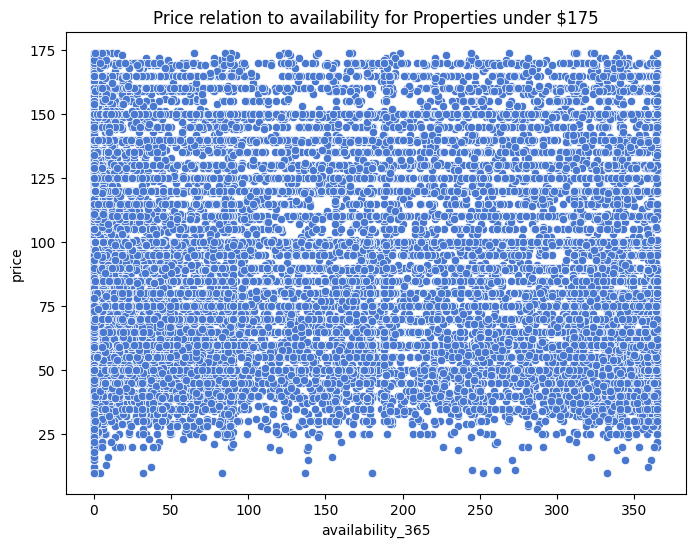

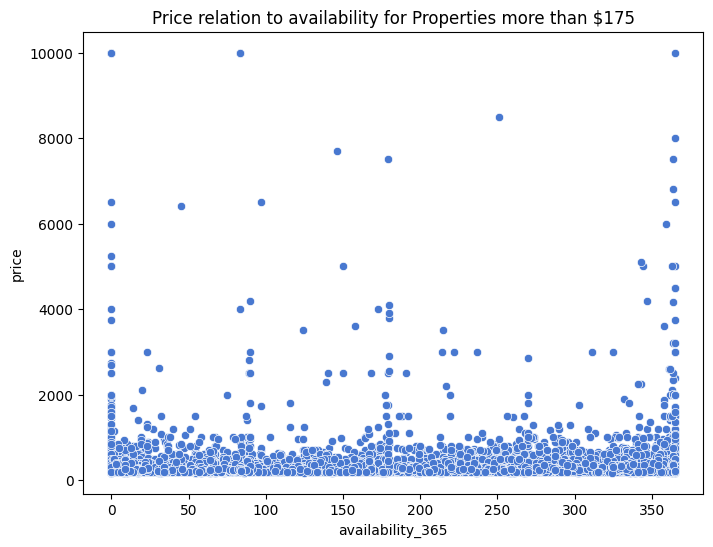

In [38]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'availability_365'
y = 'price'

title = 'Price relation to availability for Properties under $175'
data_filtered = data.loc[data['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()

title = 'Price relation to availability for Properties more than $175'
data_filtered = data.loc[data['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.show()
sns.set_palette(cbPalette)

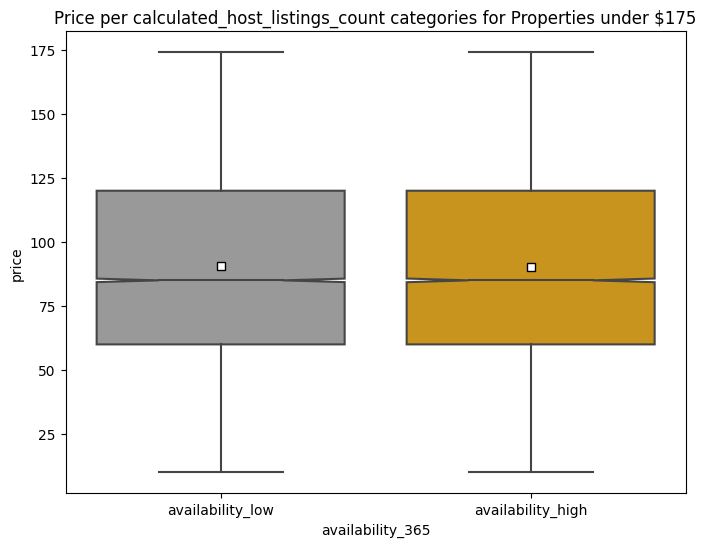

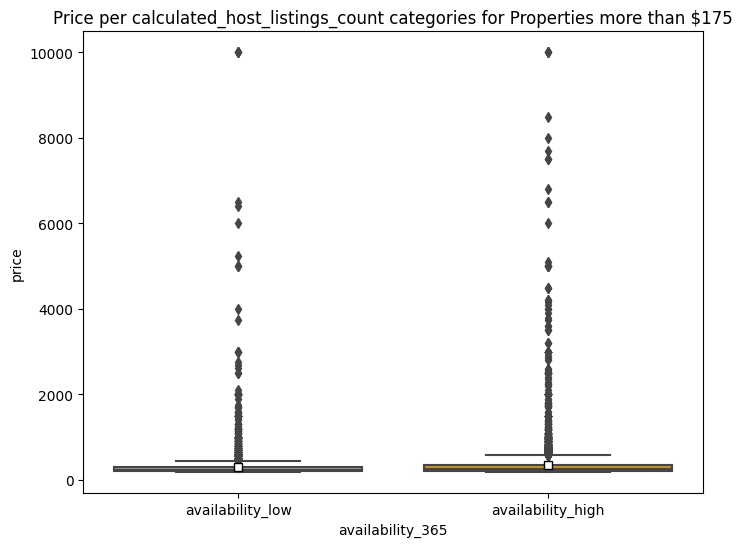

In [39]:
x = 'availability_365'
y='price'

title = 'Price per calculated_host_listings_count categories for Properties under $175'
data_filtered = data_encoded.loc[data_encoded['price'] < 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

title = 'Price per calculated_host_listings_count categories for Properties more than $175'
data_filtered = data_encoded.loc[data_encoded['price'] > 175]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

# <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">4. Train Model</div>

In [40]:
# Load the data
data = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

# Drop columns that are not of interest
data.drop(['id', 'host_name', 'last_review', 'name', 'host_id'], axis=1, inplace=True)

# Fill missing values in 'reviews_per_month' with 0
data['reviews_per_month'].fillna(0, inplace=True)

# Remove rows with price <= 0
data = data[data['price'] > 0]

# Remove outliers based on IQR
Q1 = data.quantile(0.25, numeric_only=True)
Q3 = data.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define outlier range and filter them out
numeric_columns = data.select_dtypes(include=[np.number]).columns
data = data[~((data[numeric_columns] < (Q1 - 1.5 * IQR)) | (data[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split into features and target
label = 'price'
data[label] = np.log1p(data[label])  # Log transformation of target variable to handle skewness

# Split dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Preparing training data
# Drop 'id' column if it exists (though already dropped above)
train_data = train_data.drop(columns=['id'], errors='ignore')

# Train AutoGluon model
# Setting evaluation metric to 'r2' and using advanced settings for better quality
predictor = TabularPredictor(label=label, eval_metric='r2', path='AutogluonModels/').fit(
    train_data,
    presets='best_quality',
    time_limit=TIME_LIMIT,
    num_bag_folds=5,
    num_stack_levels=2,
    verbosity=0
)

In [41]:
# Review the leaderboard of different models trained by AutoGluon
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.612082,r2,32.436368,2821.929323,0.001324,0.462686,3,True,216
1,WeightedEnsemble_L4,0.611984,r2,45.607839,4574.127324,0.001495,0.528097,4,True,317
2,WeightedEnsemble_L2,0.610971,r2,2.085665,567.183526,0.001308,0.472788,2,True,109
3,ExtraTrees_r4_BAG_L3,0.609880,r2,42.701287,4286.018437,0.839678,4.155234,3,True,278
4,CatBoost_r69_BAG_L3,0.609779,r2,41.904075,4300.916664,0.042466,19.053461,3,True,249
...,...,...,...,...,...,...,...,...,...,...
312,NeuralNetTorch_r158_BAG_L1,0.572782,r2,0.152030,150.242523,0.152030,150.242523,1,True,49
313,NeuralNetFastAI_r156_BAG_L1,0.569405,r2,0.099176,26.912998,0.099176,26.912998,1,True,41
314,NeuralNetFastAI_r100_BAG_L1,0.521943,r2,0.182432,70.595128,0.182432,70.595128,1,True,99
315,KNeighborsUnif_BAG_L1,-0.035515,r2,0.096855,0.027261,0.096855,0.027261,1,True,1


In [42]:
# Evaluate model on the test data
test_evaluation = predictor.evaluate(test_data)

In [43]:
# Predict on the test data
test_data_predictions = predictor.predict(test_data)
print(f"Evaluation Metrics: {test_evaluation}")

Evaluation Metrics: {'r2': 0.6096267497678907, 'root_mean_squared_error': -0.3464660285354577, 'mean_squared_error': -0.12003870892913258, 'mean_absolute_error': -0.2678391576876358, 'pearsonr': 0.7807946979156998, 'median_absolute_error': -0.217896902705359}


In [44]:
# Feature Importance
predictor.feature_importance(test_data)

,importance,stddev,p_value,n,p99_high,p99_low
room_type,0.714527,0.022246,1.125970e-07,5,0.760332,0.668723
longitude,0.116510,0.005231,4.862508e-07,5,0.127280,0.105739
availability_365,0.069210,0.004553,2.235196e-06,5,0.078585,0.059835
latitude,0.056046,0.005257,9.182368e-06,5,0.066871,0.045221
neighbourhood,0.016162,0.002895,1.184092e-04,5,0.022123,0.010201
minimum_nights,0.012127,0.001211,1.178412e-05,5,0.014621,0.009633
neighbourhood_group,0.012067,0.001307,1.624166e-05,5,0.014757,0.009376
reviews_per_month,0.007704,0.002375,9.585386e-04,5,0.012594,0.002815
number_of_reviews,0.005932,0.001746,8.052048e-04,5,0.009527,0.002337
calculated_host_listings_count,0.004479,0.001164,5.012902e-04,5,0.006875,0.002082


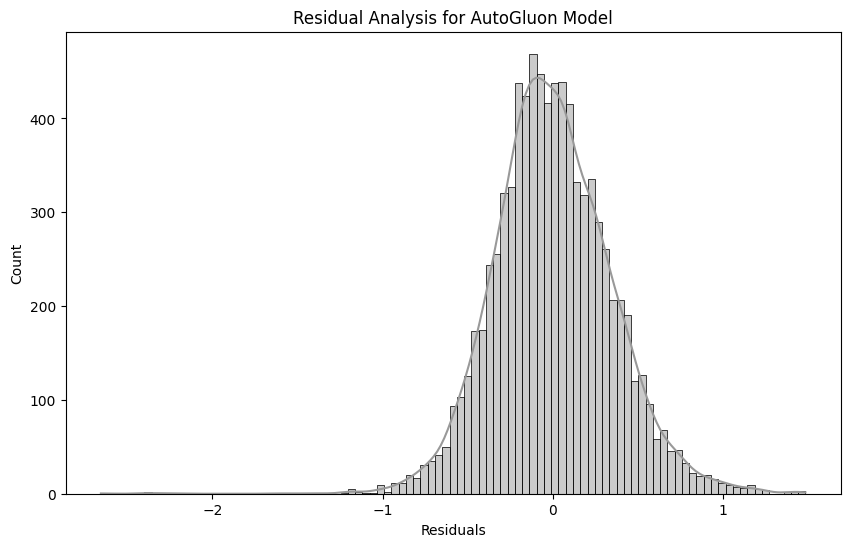

In [45]:
# Residual Analysis for Predictions
residuals = test_data[label] - test_data_predictions
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residual Analysis for AutoGluon Model")
plt.xlabel("Residuals")
plt.show()

# <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">5. Conclusion</div>

* The properties have large differences in prices.  
* Separating the dataset by price categories is useful for the analysis.
* The most interesting variables regarding price prediction are:
    * Location
    * Room type
    * calculated_host_listings_count
    * Number of review
* Price prediction models are not performing well
    * Best score is 0.55
    * Prediction are nore accurate for price under $175 (75% of the dataset)
    * Using categorical ecnoded data did not improve the model
* Possible next steps
    * The next step could be to transform continuous variables into categorical variables as it can help capture non-linear relations.
    * I doubt a neural network would be useful here because the number of observations is limited.

# <div style="background-color:#0A0F29; font-family:'Poppins',bold; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">6. References</div>

Python notebooks  

* https://www.kaggle.com/dgomonov/data-exploration-on-nyc-airbnb 
* https://www.kaggle.com/biphili/hospitality-in-era-of-airbnb
* https://www.kaggle.com/chirag9073/airbnb-analysis-visualization-and-prediction   
* https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations   
* https://www.kaggle.com/mpanfil/nyc-airbnb-data-science-ml-project  
* https://www.kaggle.com/elcaiseri/airbnb-data-exploration-on-nyc-visualization  
* https://www.kaggle.com/nidaguler/eda-and-data-visualization-ny-airbnb  
* https://www.kaggle.com/duygut/airbnb-nyc-price-prediction  

R notebooks

* https://www.kaggle.com/josipdomazet/mining-nyc-airbnb-data-using-r#data-visualisation   

Dataset discussion  

* https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/discussion/112818#latest-649615  

Machine Learning Ressources  

* https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9   
* https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html   

General Data Science Ressources
* https://datascienceguide.github.io/exploratory-data-analysis
* https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html  
* http://seaborn.pydata.org/tutorial/color_palettes.html
* https://seaborn.pydata.org/tutorial.html
* https://seaborn.pydata.org/
* https://pandas.pydata.org/pandas-docs/stable/
* https://www.kaggle.com/neomatrix369/six-steps-to-more-professional-data-science-code